# **PyTorch - Facial Similarity with Siamese Networks in Pytorch**

---


In this lesson, we will implement **Facial Similarity with Siamese Networks in Pytorch** using PyTorch. 

The goal is to teach a siamese network to be able to distinguish pairs of images. The outline of this lesson is below:

1. Load our modules, data and define some utlity functions
2. Setup our Data Processing - Create our Image Pairs
3. Building our Siamese Network
4. Start Training
5. View our Test Results

**Credits**: 

You can read the accompanying article at https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e

Source - https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch

Note: 
Any dataset can be used. Each class must be in its own folder. This is the same structure that PyTorch's own image folder dataset uses.

![](siamese_network.png)

## **Load our modules, data and define some utlity functions**

In [9]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

### **Create a simple image show and plotting function**

In [10]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### **Download our dataset - The AT&T Faces Dataset** 
Source - https://www.kaggle.com/kasikrit/att-database-of-faces

In [5]:
!pip install kagglehub


   ---------------------------------------- 0.0/44.8 kB ? eta -:--:--
   ---------------------------------------- 44.8/44.8 kB ? eta 0:00:00


DEPRECATION: textract-plus 0.1b0 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract-plus or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")

print("Path to dataset files:", path)

100%|██████████| 3.61M/3.61M [00:00<00:00, 6.09MB/s]

Extracting files...


Path to dataset files: C:\Users\saeid\.cache\kagglehub\datasets\kasikrit\att-database-of-faces\versions\2


### **Create a class that stores our parameters**

In [11]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## **Setup our Data Processing - Create our Image Pairs**

In [12]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

### **Set out image Folders**

In [13]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

### **Create our transformers**

In [14]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                                                      should_invert=False)

### **Create our Data Loader and View some sample Images**

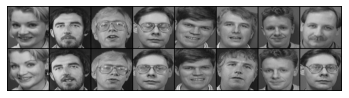

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [15]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## **Building our Siamese Network**

In [16]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),   # reflectionpad2d means padding the input with the input's reflection that work so that it repeate the edge pixel values.
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),  #The main diffrence between batch normalization and layer normalization is that batch normalization normalizes the output of a previous layer at each batch, while layer normalization normalizes the output of a previous layer for each data point.
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True), # the formula of Relu is f(x) = max(0,x) that means if x is less than 0 then it will return 0 otherwise it will return x.
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),)

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))     # 5 is the number of classes

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)    #view is used to reshape the tensor
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## **Define our Contrastive Loss Function**

In [17]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
   
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +      #The formula of contrastive loss is L=1/2 * (1-label) * D^2 + 1/2 *   where D is the euclidean distance between the two input pairs and label is the ground truth label.
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))   #clamp is used to set the minimum value of the tensor


        return loss_contrastive

### **Make our Training Data Loader**

In [21]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

### **Define our Loss and Optimizer before training**

In [22]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

## **Start Training**

c:\Users\saeid\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch number 0
 Current loss 1.3348956108093262

Epoch number 1
 Current loss 2.1150903701782227

Epoch number 2
 Current loss 1.8283512592315674

Epoch number 3
 Current loss 1.1099088191986084

Epoch number 4
 Current loss 1.0696933269500732

Epoch number 5
 Current loss 0.5561833381652832

Epoch number 6
 Current loss 0.5137332081794739

Epoch number 7
 Current loss 0.46600213646888733

Epoch number 8
 Current loss 0.44932931661605835

Epoch number 9
 Current loss 0.30105262994766235

Epoch number 10
 Current loss 0.5239342451095581

Epoch number 11
 Current loss 0.3371540307998657

Epoch number 12
 Current loss 0.22847968339920044

Epoch number 13
 Current loss 0.18189120292663574

Epoch number 14
 Current loss 0.18193170428276062

Epoch number 15
 Current loss 0.16146349906921387

Epoch number 16
 Current loss 0.12241566181182861

Epoch number 17
 Current loss 0.10338570177555084

Epoch number 18
 Current loss 0.1472787857055664

Epoch number 19
 Current loss 0.19351138174533844



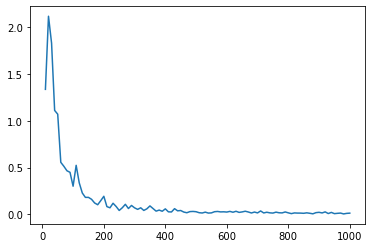

In [23]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            
show_plot(counter,loss_history)

## **View our Test Results**

The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

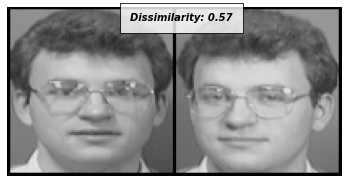

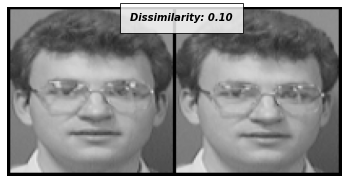

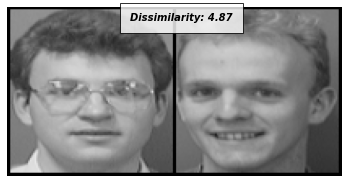

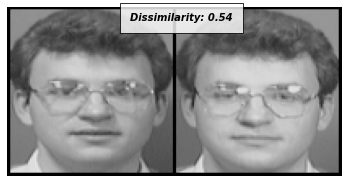

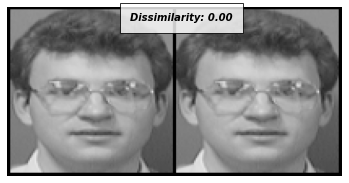

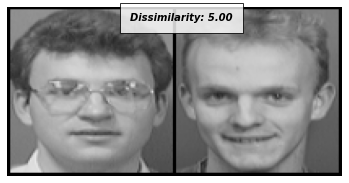

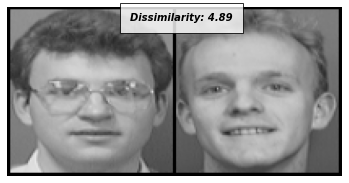

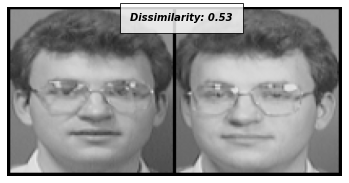

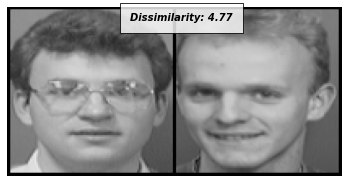

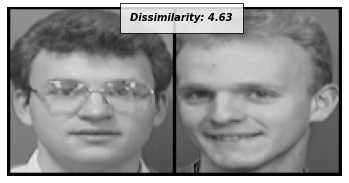

In [25]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))